# Recreating https://arxiv.org/pdf/1608.02609.pdf first for $\rho$-$\rho$ decays

## Inputs:
- Invariant masses of intermediate resonances  
- Acoplanarity angles
- Variables $y_i^+$ ($y_k^-$)
- 4 momentum of visible decay products
- 4 momentum of intermediate resonances
    - If cascade decays, need to provide 4-momenta of all $\pi^+\pi^-$ pairs which can form the resonances
- Need to boost all four vectors where primary resonances are aligned along the z-axis.
- Normalise all features

In [1]:
import uproot 
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.spatial.transform import Rotation as R
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

from pylorentz import Momentum4
from pylorentz import Position4
from lbn_modified import LBN, LBNLayer
from ROOT import TLorentzVector, TVector3

Welcome to JupyROOT 6.23/01


In [2]:
tree_tt = uproot.open("/eos/user/s/stcheung/SWAN_projects/Masters_CP/MVAFILE_AllHiggs_tt.root")["ntuple"]

variables = [
            "wt_cp_sm", "wt_cp_ps", "wt_cp_mm", "rand",
            "aco_angle_1", 
            "mva_dm_1","mva_dm_2",
            "tau_decay_mode_1","tau_decay_mode_2",
        #     "ip_x_1", "ip_y_1", "ip_z_1", "ip_x_2", "ip_y_2", "ip_z_2", # ignore impact parameter for now
            "pi_E_1", "pi_px_1", "pi_py_1", "pi_pz_1", 
            "pi_E_2", "pi_px_2", "pi_py_2", "pi_pz_2", 
            "pi0_E_1", "pi0_px_1", "pi0_py_1", "pi0_pz_1",
            "pi0_E_2", "pi0_px_2", "pi0_py_2", "pi0_pz_2", 
            "y_1_1", "y_1_2"
        ]
df = tree_tt.pandas.df(variables)
# select only rho-rho events
df_rho = df[(df['mva_dm_1']==1) & (df['mva_dm_2']==1) & (df["tau_decay_mode_1"] == 1) & (df["tau_decay_mode_2"] == 1)]
# drop unnecessary labels 
df = df_rho.drop(["mva_dm_1","mva_dm_2","tau_decay_mode_1","tau_decay_mode_2", "wt_cp_sm", "wt_cp_ps", "wt_cp_mm", "rand"], axis=1).reset_index(drop=True)

In [3]:
df.head()

,aco_angle_1,pi_E_1,pi_px_1,pi_py_1,pi_pz_1,pi_E_2,pi_px_2,pi_py_2,pi_pz_2,pi0_E_1,pi0_px_1,pi0_py_1,pi0_pz_1,pi0_E_2,pi0_px_2,pi0_py_2,pi0_pz_2,y_1_1,y_1_2
0,2.657029,45.423448,-13.747046,-38.825621,-19.153590,35.805782,8.526798,34.653880,2.904638,10.039846,-3.551914,-8.385803,-4.224041,6.112238,1.959179,5.735656,0.777900,-0.637964,-0.708372
1,1.547246,24.506373,-14.056253,9.809321,-17.514046,19.587723,8.539313,-3.149378,-17.344192,41.244844,-24.443820,15.370633,-29.451014,77.036002,32.655902,-12.032904,-68.726477,0.254573,0.594557
2,3.750274,15.319610,8.794122,0.774085,12.519393,17.469988,-9.876231,-3.253855,14.037575,69.457213,38.899682,2.503120,57.487698,56.810782,-32.919951,-10.831700,45.015529,0.638590,0.529623
3,1.192612,94.211361,42.942276,-33.711103,-76.780750,3.656937,-2.129749,0.251363,-2.958835,25.585962,11.770386,-8.993712,-20.861314,68.839211,-41.770362,4.326843,-54.546623,-0.572846,0.899114
4,3.264792,25.899289,-22.245884,-12.141924,-5.333670,23.795390,21.402816,9.436143,-4.368043,23.216735,-20.268636,-10.296444,-4.707891,18.242053,16.607666,6.693405,-3.483969,-0.054617,-0.132105


- [x] calculate 4 momentum of resonances
- [x] calculate invariant mass of resonances m^2 = E^2 - p^2
- [ ] cascades?

In [4]:
# # parse particle information
# columns = ['E', 'px', 'py', 'pz']

# pi_1 = df[['pi_E_1', "pi_px_1", "pi_py_1", "pi_pz_1"]]
# pi_2 = df[['pi_E_2', "pi_px_2", "pi_py_2", "pi_pz_2"]]
# pi0_1 = df[['pi0_E_1', "pi0_px_1", "pi0_py_1", "pi0_pz_1"]]
# pi0_2 = df[['pi0_E_2', "pi0_px_2", "pi0_py_2", "pi0_pz_2"]]

# pi_1.columns = columns
# pi_2.columns = columns
# pi0_1.columns = columns
# pi0_2.columns = columns

# # reconstruct resonance 4 momentum
# rho_1 = pi_1 + pi0_1
# rho_2 = pi_2 + pi0_2

# # calculate invariate masses
# rho_1['m'] = np.sqrt(rho_1['E']**2 - rho_1['px']**2 - rho_1['py']**2 - rho_1['pz']**2)
# rho_2['m'] = np.sqrt(rho_2['E']**2 - rho_2['px']**2 - rho_2['py']**2 - rho_2['pz']**2)

# rho_1['m'].head()

In [5]:
pi_1 = Momentum4(df['pi_E_1'], df["pi_px_1"], df["pi_py_1"], df["pi_pz_1"])
pi_2 = Momentum4(df['pi_E_2'], df["pi_px_2"], df["pi_py_2"], df["pi_pz_2"])
pi0_1 = Momentum4(df['pi0_E_1'], df["pi0_px_1"], df["pi0_py_1"], df["pi0_pz_1"])
pi0_2 = Momentum4(df['pi0_E_2'], df["pi0_px_2"], df["pi0_py_2"], df["pi0_pz_2"])
rho_1 = pi_1 + pi0_1
rho_2 = pi_2 + pi0_2
# rho_1.m is invariant mass of rhos

In [6]:
# boost into rest frame of resonances
rest_frame = pi_1 + pi_2 + pi0_1 + pi0_2
boost = Momentum4(rest_frame[0], -rest_frame[1], -rest_frame[2], -rest_frame[3])
pi_1_boosted = pi_1.boost_particle(boost)
pi_2_boosted = pi_2.boost_particle(boost)
pi0_1_boosted = pi0_1.boost_particle(boost)
pi0_2_boosted = pi0_2.boost_particle(boost)
# rho_1_boosted = rho_1.boost_particle(-rest_frame) # same result as adding the boosted 4 vectors
rho_1_boosted = pi_1_boosted + pi0_1_boosted
rho_2_boosted = pi_2_boosted + pi0_2_boosted

## rotate all vectors to align rho_1/2 with z axis
- seems rotations are wrong NEED TO FIX

In [54]:
# find angles of rho vectors to z axis
unit1 = (rho_1_boosted[1:, :] / np.linalg.norm(rho_1_boosted[1:, :], axis=0)).transpose()
unit2 = (rho_2_boosted[1:, :] / np.linalg.norm(rho_2_boosted[1:, :], axis=0)).transpose()
zaxis = np.array([np.array([0., 0., 1.]) for _ in range(len(unit1))])
angles1 = np.arccos(np.multiply(unit1, zaxis).sum(1))
angles2 = np.arccos(np.multiply(unit1, zaxis).sum(1))
axes1 = np.cross(unit1, zaxis)
axes2 = np.cross(unit2, zaxis)

In [55]:
# use scipy for rotations
# testing
r_axis = np.array([0, 1, 0])
degrees = np.pi/2
r = R.from_rotvec(r_axis*degrees)
v = [1, 0, 0]
r.apply(v)

array([ 2.22044605e-16,  0.00000000e+00, -1.00000000e+00])

In [9]:
def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

In [283]:
vec1 = [1,0,1]
vec2 = [0,0,1]
mat = rotation_matrix_from_vectors(vec1, vec2)
vec1_rot = mat.dot(vec1)
print(vec1_rot)
print(mat.dot([1,1,0]))


[0.         0.         1.41421356]
[0.70710678 1.         0.70710678]
1.4142135623730951


In [253]:
a = TVector3(1,1,1)
b = TVector3(1,1,1)
a.RotateUz(b)
print(a.x(), a.y(), a.z())

1.0 2.414213562373095 1.0


In [205]:
a = np.array([0, 1, 1])
axis = np.array([0,0,1])
R.from_rotvec(np.cross(axis, a)*np.arccos(a.dot(axis))).apply(a)

array([0., 1., 1.])

In [132]:
R.from_rotvec(np.array([0,0,1])*np.pi/4).apply(np.array([1,1,1]))

array([-1.11022302e-16,  1.41421356e+00,  1.00000000e+00])

In [271]:
pi_1_boosted[1:,].T

array([[  4.11524295, -20.93998193,  32.4830385 ],
       [-14.33910509,   8.76007675,  -3.55210406],
       [  8.29648612,   1.87229655,  -0.59411126],
       ...,
       [-47.73288845,  -5.55664845,   1.79538896],
       [ -0.97339735,  -1.69719525,  -0.20591042],
       [ 14.57215557,   1.08451334,  -3.41346363]])

In [276]:
rot_1_mat = rotation_matrix_from_vectors(rho_1_boosted[1:, 0], [0,0,1])

In [279]:
rot_1_mat.dot(pi_2_boosted[1:, 0])

array([ -0.25884649,   0.44923938, -40.45288205])

In [22]:
rot_mat = rotation_matrix_from_vectors(rho_1_boosted[1:, 0], [0,0,1])
print(rot_mat.dot(rho_1_boosted[1:, 0]))
print(rot_mat.dot(pi_1_boosted[1:, 0]), rot_mat.dot(pi0_1_boosted[1:, 0]), rot_mat.dot(pi0_1_boosted[1:, 0])+rot_mat.dot(pi_1_boosted[1:, 0]))


[ 0.          0.         47.42022064]
[ 0.38003135 -0.24022158 38.8633983 ] [-0.38003135  0.24022158  8.55682233] [-1.11022302e-16  1.33226763e-15  4.74202206e+01]


In [21]:
# new version
pi_1_boosted_rot = []
pi_2_boosted_rot = []
pi0_1_boosted_rot = []
pi0_2_boosted_rot = []
rho_1_boosted_rot = []
rho_2_boosted_rot = []

for i in range(pi_1_boosted[:].shape[1]):
    rot_mat = rotation_matrix_from_vectors(rho_1_boosted[1:, i], [0,0,1])
    pi_1_boosted_rot.append(rot_mat.dot(pi_1_boosted[1:, i]))
    pi0_1_boosted_rot.append(rot_mat.dot(pi0_1_boosted[1:, i]))
    pi_2_boosted_rot.append(rot_mat.dot(pi_2_boosted[1:, i]))
    pi0_2_boosted_rot.append(rot_mat.dot(pi0_2_boosted[1:, i]))
    rho_1_boosted_rot.append(rot_mat.dot(rho_1_boosted[1:, i]))
    rho_2_boosted_rot.append(rot_mat.dot(rho_2_boosted[1:, i]))
    
    if i%100000==0:
        print('finished getting rotated 4-vector', i)

finished getting rotated 4-vector 0
finished getting rotated 4-vector 100000
finished getting rotated 4-vector 200000
finished getting rotated 4-vector 300000
finished getting rotated 4-vector 400000
finished getting rotated 4-vector 500000
finished getting rotated 4-vector 600000


In [16]:
rho_2_boosted_rot[0]+rho_1_boosted_rot[0]

array([ 1.95399252e-14,  3.55271368e-14, -3.55271368e-14])

In [19]:
# old version
pi_1_boosted_rot = []
pi_2_boosted_rot = []
pi0_1_boosted_rot = []
pi0_2_boosted_rot = []
rho_1_boosted_rot = []
rho_2_boosted_rot = []

for i in range(pi_1_boosted[:].shape[1]):
    pi_1_boosted_rot.append(R.from_rotvec(axes1[i]*angles1[i]).apply(pi_1_boosted[1:, i]))
    pi_2_boosted_rot.append(R.from_rotvec(axes2[i]*angles2[i]).apply(pi_2_boosted[1:, i]))
    pi0_1_boosted_rot.append(R.from_rotvec(axes1[i]*angles1[i]).apply(pi0_1_boosted[1:, i]))
    pi0_2_boosted_rot.append(R.from_rotvec(axes2[i]*angles2[i]).apply(pi0_2_boosted[1:, i]))
    rho_1_boosted_rot.append(R.from_rotvec(axes1[i]*angles1[i]).apply(rho_1_boosted[1:, i]))
    rho_2_boosted_rot.append(R.from_rotvec(axes2[i]*angles2[i]).apply(rho_2_boosted[1:, i]))
    if i%100000==0:
        print('finished getting rotated 4-vector', i)

NameError: name 'axes1' is not defined

In [22]:
pi_1_transformed = np.c_[pi_1_boosted[0], np.array(pi_1_boosted_rot)]
pi_2_transformed = np.c_[pi_2_boosted[0], np.array(pi_2_boosted_rot)]
pi0_1_transformed = np.c_[pi0_1_boosted[0], np.array(pi0_1_boosted_rot)]
pi0_2_transformed = np.c_[pi0_2_boosted[0], np.array(pi0_2_boosted_rot)]
rho_1_transformed = np.c_[rho_1_boosted[0], np.array(rho_1_boosted_rot)]
rho_2_transformed = np.c_[rho_2_boosted[0], np.array(rho_2_boosted_rot)]

In [50]:
pi0_1_transformed[0]

array([ 8.56968708, -0.42942941,  0.1331188 ,  8.55682233])

In [35]:
# create features and target
# normalise each feature column?
aco_angle_1 = df['aco_angle_1'].to_numpy()
y_1_1 = df['y_1_1'].to_numpy()
y_1_2 = df['y_1_2'].to_numpy()
X = np.c_[pi_1_transformed, pi_2_transformed, pi0_1_transformed, pi0_2_transformed, rho_1_transformed, rho_2_transformed, aco_angle_1 , y_1_1, y_1_2, rho_1.m, rho_2.m]

In [ ]:
# set a is sm, set b is ps
y = (df_rho['wt_cp_sm']/(df_rho['wt_cp_sm'] + df_rho['wt_cp_ps'])).to_numpy()

In [13]:
print(X.shape)
print(y.shape)

(653528, 21)
(653528,)


In [14]:
scaler_x = MinMaxScaler()
scaler_x.fit(X)
X=scaler_x.transform(X)
X_train,X_test, y_train, y_test  = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=123456,
#     stratify=y.values,
)

In [20]:
# read data instead
X = np.load('potential_2016/X.npy', allow_pickle=True)
y = np.load('potential_2016/y.npy', allow_pickle=True)
X_train,X_test, y_train, y_test  = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=123456,
#     stratify=y.values,
)

## partitioning the input/output data
### from paper
- [ ] aco_angle_1
- [ ] aco_angle_1, y_1_{1,2}
- [ ] 4 vectors
- [ ] aco_angle_1, 4 vectors
- [ ] aco_angle_1, y_1_{1,2}, invariant masses
- [ ] aco_angle_1, y_1_{1,2}, invariant masses, 4 vectors

In [290]:
to_save = [pi_1_transformed, pi_2_transformed, pi0_1_transformed, pi0_2_transformed, rho_1_transformed, rho_2_transformed, aco_angle_1, y_1_1, y_1_2, rho_1.m, rho_2.m]
to_save_names = ["pi_1_transformed", "pi_2_transformed", "pi0_1_transformed", "pi0_2_transformed", "rho_1_transformed", "rho_2_transformed", "aco_angle_1", "y_1_1", "y_1_2", "m_1", "m_2"]
for i in range(len(to_save)):
    np.save(f'potential_2016/{to_save_names[i]}', to_save[i], allow_pickle=True)

In [2]:
to_load = []
to_load_names = ["pi_1_transformed", "pi_2_transformed", "pi0_1_transformed", "pi0_2_transformed", "rho_1_transformed", "rho_2_transformed", "aco_angle_1", "y_1_1", "y_1_2", "m_1", "m_2", "w_a", "w_b"]
for i in range(len(to_load_names)):
    to_load.append(np.load(f'potential_2016/{to_load_names[i]}.npy', allow_pickle=True))
pi_1_transformed, pi_2_transformed, pi0_1_transformed, pi0_2_transformed, rho_1_transformed, rho_2_transformed, aco_angle_1, y_1_1, y_1_2, m_1, m_2, w_a, w_b = to_load

In [44]:
rho_1_transformed

array([[-4.74359363e+01,  0.00000000e+00,  0.00000000e+00,
         4.74202206e+01],
       [-4.62640934e+01,  1.06581410e-14, -4.44089210e-15,
         4.62509078e+01],
       [-4.61043317e+01,  1.77635684e-15,  1.11022302e-15,
         4.60969780e+01],
       ...,
       [-5.07845711e+01,  1.17683641e-14,  3.05311332e-16,
         5.07785110e+01],
       [-3.52246892e+01, -3.99680289e-15, -7.10542736e-15,
         3.52191327e+01],
       [-2.81963640e+01, -5.32907052e-15, -1.11022302e-16,
         2.81858674e+01]])

In [87]:
# X = np.c_[pi_1_transformed, pi_2_transformed, pi0_1_transformed, pi0_2_transformed, rho_1_transformed, rho_2_transformed, aco_angle_1 , y_1_1, y_1_2, m_1, m_2]
X = np.c_[pi_1_transformed, pi_2_transformed, pi0_1_transformed, pi0_2_transformed, aco_angle_1 , y_1_1, y_1_2, m_1, m_2]
y = w_a/(w_a+w_b)
# scaler_x = MinMaxScaler()
# scaler_x.fit(X)
# X=scaler_x.transform(X)
X_train,X_test, y_train, y_test  = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=123456,
#     stratify=y.values,
)

In [43]:
y_d = (~(df_rho["rand"]<df_rho["wt_cp_ps"]/2).to_numpy()).astype(int)

In [44]:
y_d.shape

(653528,)

In [41]:
df_ps = df_rho[
      (df_rho["rand"]<df_rho["wt_cp_ps"]/2)
]

df_sm = df_rho[
      (df_rho["rand"]<df_rho["wt_cp_sm"]/2)
]
y_sm = pd.DataFrame(np.ones(df_sm.shape[0]))
y_ps = pd.DataFrame(np.zeros(df_ps.shape[0]))

y = pd.concat([y_sm, y_ps])
y.columns = ["class"]

In [37]:
X = pd.concat([df_sm, df_ps])

In [36]:
X.shape

(653528, 29)

In [56]:
y.to_numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'type'

## NN configuration
- output is probability of event belonging to set A
- need to add batch normalisation and dropout
- can rerun couple times to see average perfomance

In [23]:
def baseline_model():
    # create model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(300, activation='relu'))
    model.add(tf.keras.layers.Dense(300, activation='relu'))
    model.add(tf.keras.layers.Dense(300, activation='relu'))
#     model.add(tf.keras.layers.Dense(300, activation='relu'))
#     model.add(tf.keras.layers.Dense(300, activation='relu'))
#     model.add(tf.keras.layers.Dense(300, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    model.compile(loss='binary_crossentropy', optimizer='adam')

    return model

model = baseline_model()

In [99]:
def kristof_model(dimensions=-1):
    if dimensions == -1:
        dimensions = X.shape[1]
    # create model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(38, input_dim=dimensions, kernel_initializer='normal', activation='relu'))
    model.add(tf.keras.layers.Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    model.compile(loss='binary_crossentropy', optimizer='adam')  
    return model
model = kristof_model(X.shape[1])

In [41]:
def func_model(units=[300,300], activations=['relu', 'relu']):
    if len(units) != len(activations):
        raise InputError('units and activations have different lengths')
    layers = len(units)
    inputs = tf.keras.Input(shape=(X.shape[1],))
    x = inputs
    
    for i in range(layers):
        x = tf.keras.layers.Dense(units[i], activation=activations[i], kernel_initializer='normal')(x)

    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam')
    print(model.summary())
    return model
model = func_model()

# tf.keras.utils.plot_model(model, "y_network.png", show_shapes=True, expand_nested=False)

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 300)               9000      
_________________________________________________________________
dense_7 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 301       
Total params: 99,601
Trainable params: 99,601
Non-trainable params: 0
_________________________________________________________________
None


## investigation
- batch normalisation: check if after activation or before activation function is better
- dropout layers

In [89]:
X.shape

(653528, 21)

In [100]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
history = tf.keras.callbacks.History()
model.fit(X_train, y_train,
            batch_size=10000,
            epochs=20,
            callbacks=[history,early_stop],
            validation_data=(X_test, y_test))

W1109 16:26:58.536243 140178397140800 ag_logging.py:146] AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7f7bc53c4c20> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
49/53 [==========================>...] - ETA: 0s - loss: 0.6973

W1109 16:27:01.256816 140178397140800 ag_logging.py:146] AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f7bea68ce60> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
53/53 [==============================] - 2s 32ms/step - loss: 0.6971 - val_loss: 0.6932
Epoch 2/20
53/53 [==============================] - 1s 23ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 3/20
53/53 [==============================] - 1s 26ms/step - loss: 0.6930 - val_loss: 0.6929
Epoch 4/20
53/53 [==============================] - 1s 26ms/step - loss: 0.6925 - val_loss: 0.6917
Epoch 5/20
53/53 [==============================] - 1s 25ms/step - loss: 0.6895 - val_loss: 0.6865
Epoch 6/20
53/53 [==============================] - 1s 26ms/step - loss: 0.6844 - val_loss: 0.6828
Epoch 7/20
53/53 [==============================] - 1s 25ms/step - loss: 0.6821 - val_loss: 0.6819
Epoch 8

In [82]:
y_pred = model.predict(X)
test_loss = model.evaluate(X, y)

W1109 16:17:54.827726 140178397140800 ag_logging.py:146] AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7f7bc9473cb0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
20423/20423 [==============================] - 14s 701us/step - loss: 0.6808


In [43]:
# creating custom ROC
set_a = np.ones(len(y))
set_b = np.zeros(len(y))

# w_a = (df_rho['wt_cp_sm']/(df_rho['wt_cp_sm'] + df_rho['wt_cp_ps'])).to_numpy()
# w_b = (df_rho['wt_cp_ps']/(df_rho['wt_cp_sm'] + df_rho['wt_cp_ps'])).to_numpy()

In [ ]:
w_a = np.load('potential_2016/w_a.npy', allow_pickle=True)
w_b = np.load('potential_2016/w_b.npy', allow_pickle=True)

In [83]:
y_pred_roc = np.r_[y_pred, y_pred]
y_label_roc = np.r_[set_a, set_b]
w_roc = np.r_[w_a, w_b]

In [84]:
custom_auc = roc_auc_score(y_label_roc, y_pred_roc, sample_weight=w_roc)
custom_auc

0.5845869981043447

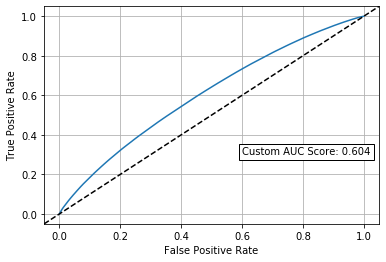

In [48]:
fpr, tpr, _ = roc_curve(y_label_roc, y_pred_roc, sample_weight=w_roc)
plot_roc_curve(fpr, tpr, custom_auc)


In [47]:
#  define a function to plot the ROC curves - just makes the roc_curve look nicer than the default
def plot_roc_curve(fpr, tpr, auc):
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr)
    ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    ax.grid()
    ax.text(0.6, 0.3, 'Custom AUC Score: {:.3f}'.format(auc),
            bbox=dict(boxstyle='square,pad=0.3', fc='white', ec='k'))
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
    ax.plot(lims, lims, 'k--')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    plt.savefig('roc_rho_rho_NN')

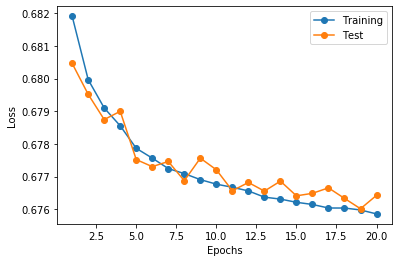

In [16]:
# Extract number of run epochs from the training history
epochs = range(1, len(history.history["loss"])+1)

# Extract loss on training and validation ddataset and plot them together
plt.plot(epochs, history.history["loss"], "o-", label="Training")
plt.plot(epochs, history.history["val_loss"], "o-", label="Test")
plt.xlabel("Epochs"), plt.ylabel("Loss")
# plt.yscale("log")
plt.legend()

In [3]:
model_2 = tf.keras.models.load_model('potential_2016/NN_1')

2020-11-09 14:16:57.186656: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2020-11-09 14:16:57.319925: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2399960000 Hz
2020-11-09 14:16:57.326192: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x17f4efa0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-11-09 14:16:57.326239: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [6]:
y_pred = model_2.predict(X)
y_pred_roc = np.r_[y_pred, y_pred]
y_label_roc = np.r_[set_a, set_b]
w_roc = np.r_[w_a, w_b]
custom_auc = roc_auc_score(y_label_roc, y_pred_roc, sample_weight=w_roc)
custom_auc

W1109 14:17:23.320142 140178397140800 ag_logging.py:146] AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7f7cc838f290> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


NameError: name 'set_a' is not defined

In [46]:
# theoretical limit
y = w_a/(w_a+w_b)
set_a = np.ones(len(y))
set_b = np.zeros(len(y))
y_pred_roc = np.r_[y, y]
y_label_roc = np.r_[set_a, set_b]
w_roc = np.r_[w_a, w_b]
custom_auc = roc_auc_score(y_label_roc, y_pred_roc, sample_weight=w_roc)
custom_auc

0.7751572527012546

In [ ]:
# sanity check of roc score
X_train,X_test, y_train, y_test  = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=123456,
#     stratify=y.values,
)

In [70]:
w_a_train, w_a_test, w_b_train, w_b_test = train_test_split(w_a, w_b, test_size=0.2, random_state=123456)

In [54]:
def custom_auc_score(pred, w_a, w_b):
    set_a = np.ones(len(pred))
    set_b = np.zeros(len(pred))
    y_pred_roc = np.r_[pred, pred]
    y_label_roc = np.r_[set_a, set_b]
    w_roc = np.r_[w_a, w_b]
    custom_auc = roc_auc_score(y_label_roc, y_pred_roc, sample_weight=w_roc)
    return custom_auc

In [101]:
y_pred_test = model.predict(X_test)
test_auc = custom_auc_score(y_pred_test, w_a_test, w_b_test)
y_pred_train = model.predict(X_train)
train_auc = custom_auc_score(y_pred_train, w_a_train, w_b_train)
y_pred = model.predict(X)
auc = custom_auc_score(y_pred, w_a, w_b)

W1109 16:27:28.111766 140178397140800 ag_logging.py:146] AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7f7bea7e4710> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [102]:
print(test_auc, train_auc, auc)

0.5929943614390831 0.5930850939054201 0.5930668913683725
